Evaluate an instance of **FASTSRegressor** to make forecasts of the number of Medium Posts. 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from io import StringIO

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from IPython.display import HTML, display
pd.options.plotting.backend = "plotly"

import datetime
from time import time

import warnings
warnings.filterwarnings('ignore')

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12, 6

import sys
# sys.path.append("C:\\PROGRAMMAZIONE\\Sviluppo\\AI\\MachineLearning\\timeseries\\projects\\fasts")

from fasts import estimators as es
from fasts import valid as vd
from fasts import utils as us
from fasts.datasets import load_data

from sklearn.metrics import mean_squared_error

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
posts = load_data("mediumposts.csv")
display(posts)

published
2015-01-01      8
2015-01-02     11
2015-01-03     11
2015-01-04      8
2015-01-05     27
             ... 
2017-06-21    422
2017-06-22    441
2017-06-23    421
2017-06-24    277
2017-06-25    253
Name: posts, Length: 907, dtype: int64

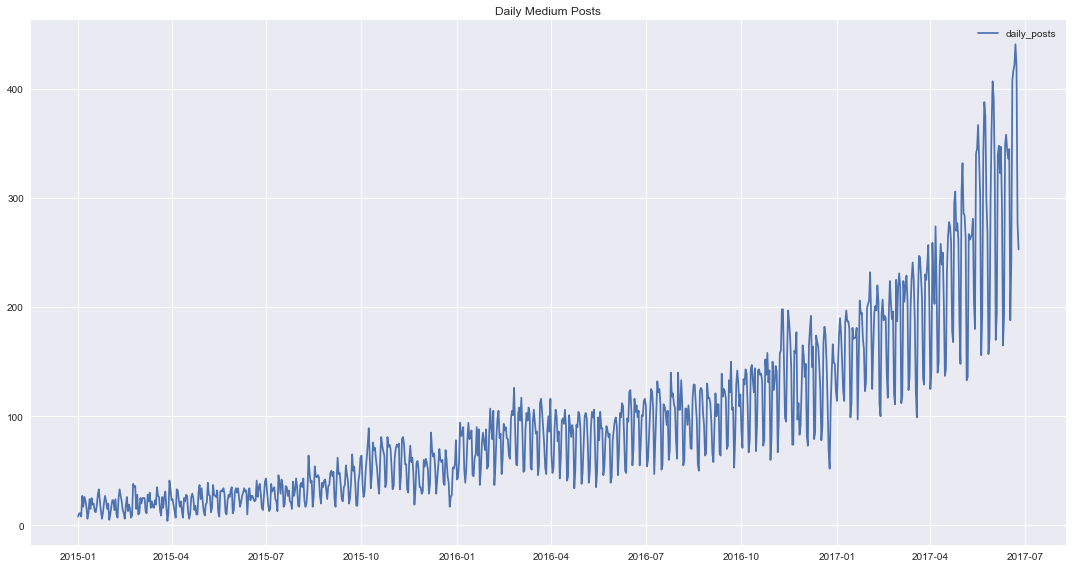

In [3]:
plt.figure(figsize=(15, 8))
plt.plot(posts, label="daily_posts")
plt.title("Daily Medium Posts")
plt.legend()    
plt.tight_layout()

Likely, there's a weekly component.

In [4]:
n_jobs=-1
# 5, 10, 15, 25, 50, 75
n_iter=25
# forecasting horizon: 
# daily: 10, 14 - two weeks - 28, four weeks
fh=28
test_size=fh
n_lags=21

## Power Transformations

Stabilize variance, make data more gaussian-like... Probably not necessary though.

In [5]:
posts.min()

4

Values are positive, you don't need to min-max scale them.

In [6]:
# perform a box-cox transform of the dataset
scaler = MinMaxScaler(feature_range=(1, 10))
# method='box-cox'
# power = PowerTransformer(standardize=False, method='box-cox')
# pipeline = Pipeline(steps=[('s', scaler),('p', power)])

In [7]:
power = PowerTransformer(method='box-cox')

### PowerTransform

In [8]:
posts_y_scale_bc = power.fit_transform(posts.values.reshape(-1, 1)).ravel()
posts_y_scale_bc[:10]

array([-2.09499778, -1.8317227 , -1.8317227 , -2.09499778, -1.01597853,
       -1.4503129 , -1.05258069, -1.17002944, -1.4503129 , -2.32199306])

In [9]:
len(posts_y_scale_bc)

907

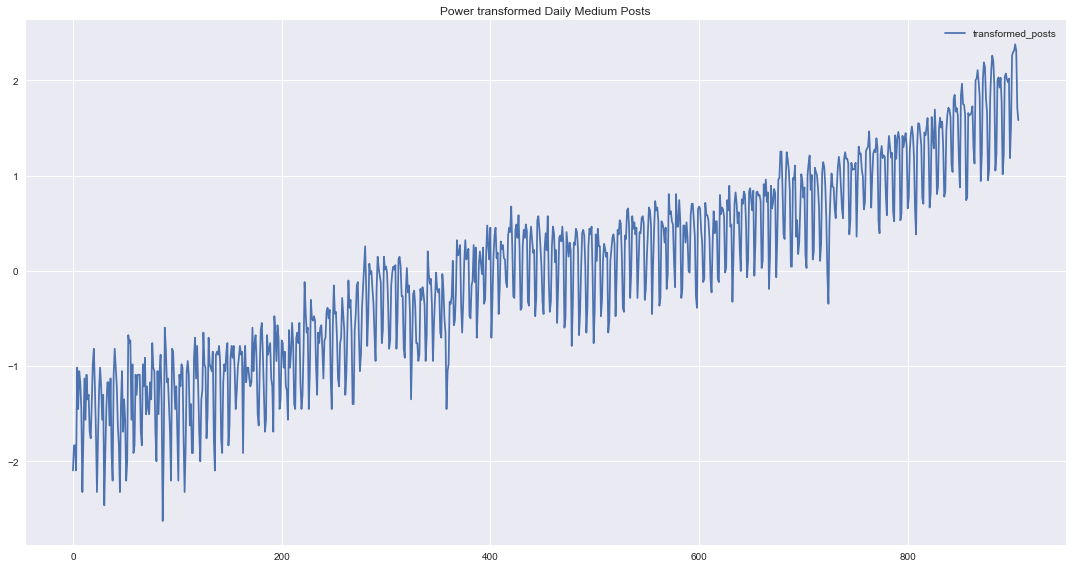

In [10]:
plt.figure(figsize=(15, 8))
plt.plot(posts_y_scale_bc, label="transformed_posts")
plt.title("Power transformed Daily Medium Posts")
plt.legend()    
plt.tight_layout()

In [11]:
X, y = us.embed_to_X_y(
    pd.Series(posts_y_scale_bc), 
    n_lags=n_lags, name='posts')

In [12]:
y.min()

-2.625336062600278

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, shuffle=False)

In [14]:
display(X_train)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
0,-0.817750,-0.980506,-1.398309,-1.757515,-1.688369,-1.301242,-1.348694,-1.090394,-1.562605,-1.129510,...,-2.321993,-1.450313,-1.170029,-1.052581,-1.450313,-1.015979,-2.094998,-1.831723,-1.831723,-2.094998
1,-1.212068,-0.817750,-0.980506,-1.398309,-1.757515,-1.688369,-1.301242,-1.348694,-1.090394,-1.562605,...,-1.757515,-2.321993,-1.450313,-1.170029,-1.052581,-1.450313,-1.015979,-2.094998,-1.831723,-1.831723
2,-1.688369,-1.212068,-0.817750,-0.980506,-1.398309,-1.757515,-1.688369,-1.301242,-1.348694,-1.090394,...,-1.129510,-1.757515,-2.321993,-1.450313,-1.170029,-1.052581,-1.450313,-1.015979,-2.094998,-1.831723
3,-2.321993,-1.688369,-1.212068,-0.817750,-0.980506,-1.398309,-1.757515,-1.688369,-1.301242,-1.348694,...,-1.562605,-1.129510,-1.757515,-2.321993,-1.450313,-1.170029,-1.052581,-1.450313,-1.015979,-2.094998
4,-1.757515,-2.321993,-1.688369,-1.212068,-0.817750,-0.980506,-1.398309,-1.757515,-1.688369,-1.301242,...,-1.090394,-1.562605,-1.129510,-1.757515,-2.321993,-1.450313,-1.170029,-1.052581,-1.450313,-1.015979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2.188591,2.001200,1.224930,0.942486,1.823626,1.980000,2.107381,2.017972,2.001200,1.126818,...,1.727222,1.656222,1.640599,1.630100,1.656222,0.769525,0.741749,1.640599,1.742045,1.751854
854,2.138771,2.188591,2.001200,1.224930,0.942486,1.823626,1.980000,2.107381,2.017972,2.001200,...,1.297899,1.727222,1.656222,1.640599,1.630100,1.656222,0.769525,0.741749,1.640599,1.742045
855,1.809518,2.138771,2.188591,2.001200,1.224930,0.942486,1.823626,1.980000,2.107381,2.017972,...,1.126818,1.297899,1.727222,1.656222,1.640599,1.630100,1.656222,0.769525,0.741749,1.640599
856,1.666555,1.809518,2.138771,2.188591,2.001200,1.224930,0.942486,1.823626,1.980000,2.107381,...,2.001200,1.126818,1.297899,1.727222,1.656222,1.640599,1.630100,1.656222,0.769525,0.741749


In [15]:
y_train.min()

-2.625336062600278

In [16]:
fasts = es.FASTSRegressor(
    # lasso_alpha=0.01,
    quantile_reg=True,
    )
fasts_params = vd.fasts_param_distros

In [17]:
fasts_params

{'lasso_alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x229a58279c8>,
 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen at 0x229a5827ec8>,
 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x229a582a048>,
 'subsample': <scipy.stats._distn_infrastructure.rv_frozen at 0x229a5827888>,
 'max_features': [None, 0.75, 0.5, 'log2'],
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x229a582adc8>,
 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x229a582ae88>}

In [18]:
display(X_train.head(3))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
0,-0.817750,-0.980506,-1.398309,-1.757515,-1.688369,-1.301242,-1.348694,-1.090394,-1.562605,-1.129510,...,-2.321993,-1.450313,-1.170029,-1.052581,-1.450313,-1.015979,-2.094998,-1.831723,-1.831723,-2.094998
1,-1.212068,-0.817750,-0.980506,-1.398309,-1.757515,-1.688369,-1.301242,-1.348694,-1.090394,-1.562605,...,-1.757515,-2.321993,-1.450313,-1.170029,-1.052581,-1.450313,-1.015979,-2.094998,-1.831723,-1.831723
2,-1.688369,-1.212068,-0.817750,-0.980506,-1.398309,-1.757515,-1.688369,-1.301242,-1.348694,-1.090394,...,-1.129510,-1.757515,-2.321993,-1.450313,-1.170029,-1.052581,-1.450313,-1.015979,-2.094998,-1.831723


In [19]:
# %time fasts.fit(X_train, y_train)

In [20]:
print("=== TS Randomized Search CV...")
print()

rscv = vd.TSRandomizedSearchCV(
    estimator=fasts, n_split=3, param_distro=fasts_params, fh=fh, 
    test_size=test_size, n_iter=n_iter, 
    n_jobs=n_jobs
)

failed = 0
try:
    t0 = time()
    rscv.fit(X_train, y_train)
    t1 = time()
except ValueError as ve:
    failed = 1
    print("ValueError:", ve)
    # adjust learning_rate distro for spanning little numbers?
    fasts_params["lasso_alpha"] = vd.loguniform(1e-3, 1e-1)
    # fasts_params["learning_rate"] = vd.loguniform(1e-4, 1e-2)
except Exception as e:
    failed = 1
    print("Mysterious Exception:", e)

=== TS Randomized Search CV...

ValueError: Found array with 0 feature(s).


In [21]:
# ? adjust learning_rate distro for spanning little numbers?
# fasts_params["lasso_alpha"] = vd.loguniform(1e-3, 1e-2)

In [22]:
if failed:
    try:
        t0 = time()
        rscv.fit(X_train, y_train)
        t1 = time()
    except ValueError as ve:
        print("ValueError:", ve)
    except Exception as e:
        print("Mysterious Exception:", e)

Best validation rmse score overall: 0.247 ± 0.060
Refitting best estimator...
X cols 21
X_sel_ cols 16
with quantile regression.
self.gbr_fitted_.n_features = 16


#### Prune bootstrapped forecasts

Full time of Search: 92.01 s

=== Compare best estimator to baselines on test data...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[1.0678161542478684, 0.9506308922633472, 1.6665547468478978, 1.8095179879000935, 2.138770795093222, 2.188590843854221, 2.0012003176857065, 1.22493007195354, 0.9424863277803812, 1.82362643633907, 1.9799996730908356, 2.1073811192397116, 2.0179722749983986, 2.0012003176857065, 1.1268177123988736, 1.2978990438288813, 1.7272216219018601, 1.6562218264100328, 1.6405989718701914, 1.6301000730841109, 1.6562218264100328]
length of first Lasso test window: 21
[-0.04768390887988172, -0.1579922907140826, -0.06667926621376474, -0.1347762614713235, 0.18718952923137722, 0.1933611106945019, 0.14038315109555555, 0.17751418854302625, -0.2992921096275114, 0.06245126642084675, 0.1273443340280178, 0.33848701342858534, 0.08708119306882756, 0.22618075507112434, 0.09363812323903331, 0.2078608434088327]
length

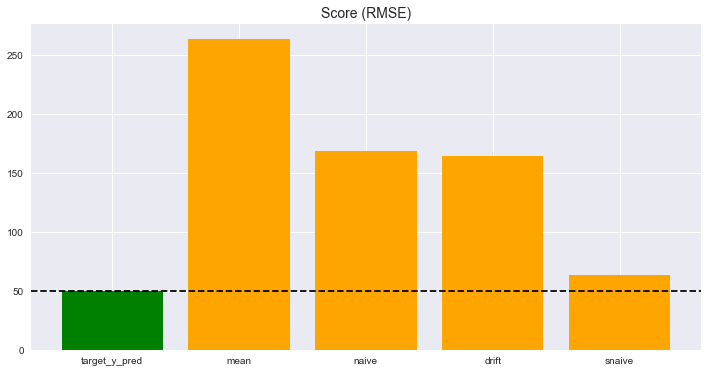

In [23]:
print(f"Full time of Search: {(t1 - t0):.2f} s")
print()

best_fasts = rscv.best_params_['best_estimator']

print("=== Compare best estimator to baselines on test data...")

scores, spreds_pruned, tgt_preds_pruned = best_fasts.compare_to_baselines(
    y_train, 
    y_test, 
    # posts[-fh:],
    season=7,
    fh=fh, 
    bar_plot=True,
    bck_transformer=power,
    prune=True
);


full_time_series_df
            orig_scale_posts   forecasts  y_test       mean  naive  \
published                                                            
2017-06-21               NaN  366.108281   422.0  69.591764  172.0   
2017-06-22               NaN  338.557201   441.0  69.591764  172.0   
2017-06-23               NaN  291.277528   421.0  69.591764  172.0   
2017-06-24               NaN  205.928262   277.0  69.591764  172.0   
2017-06-25               NaN  214.176077   253.0  69.591764  172.0   

                 drift  snaive      low_80       up_80      low_95  \
published                                                            
2017-06-21  180.440283   375.0  134.117668  873.532177   73.301428   
2017-06-22  180.440283   298.0  170.202952  630.517386  114.402588   
2017-06-23  180.440283   269.0   99.136057  733.990068   51.512085   
2017-06-24  181.829759   157.0   54.069089  623.933464   23.320763   
2017-06-25  181.829759   172.0   66.054585  579.687143   32.027047  

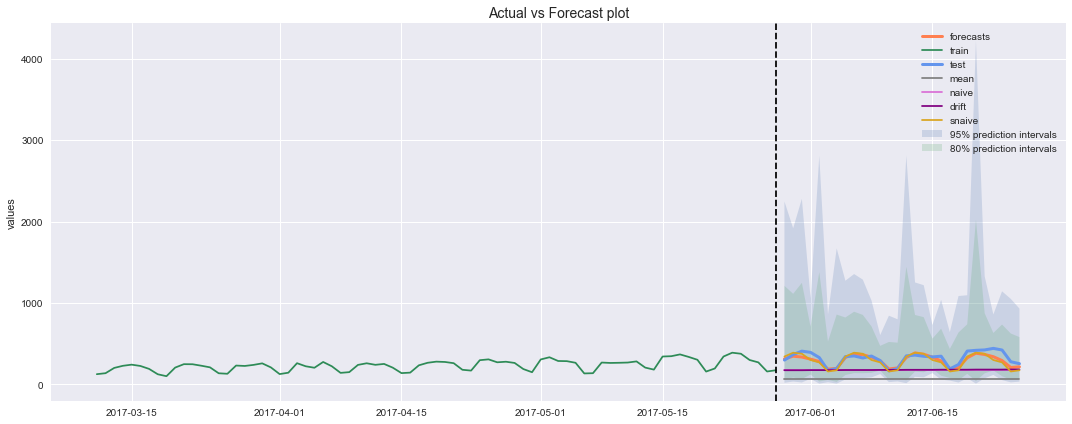

In [24]:
us.plot_forecasts(
    posts[800:-fh],
    tgt_preds_pruned[tgt_preds_pruned > 0].fillna(0),
    posts.index[800:], 
    y_test=posts[-fh:],
    simple_preds=spreds_pruned,
    return_pred_int=True)

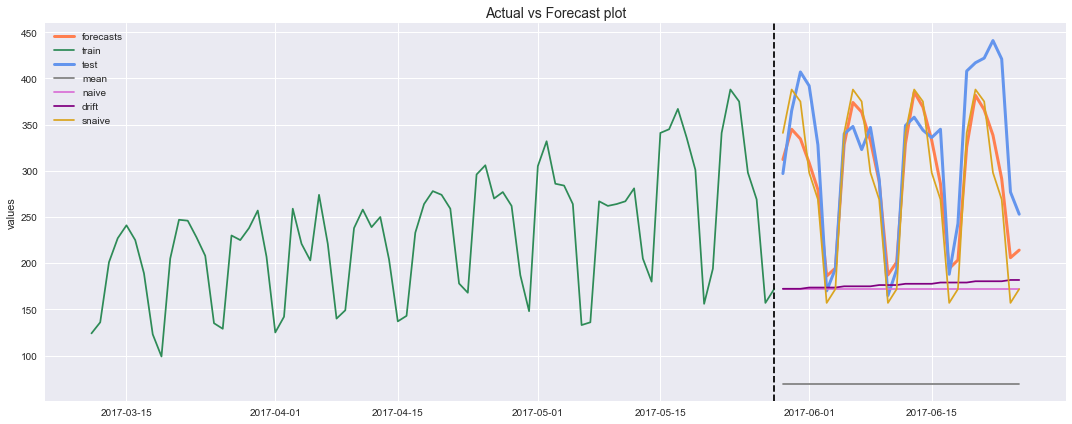

In [25]:
us.plot_forecasts(
    posts[800:-fh],
    tgt_preds_pruned[tgt_preds_pruned > 0].fillna(0),
    posts.index[800:], 
    y_test=posts[-fh:],
    simple_preds=spreds_pruned)

Seasonal naive is a competitive forecast.

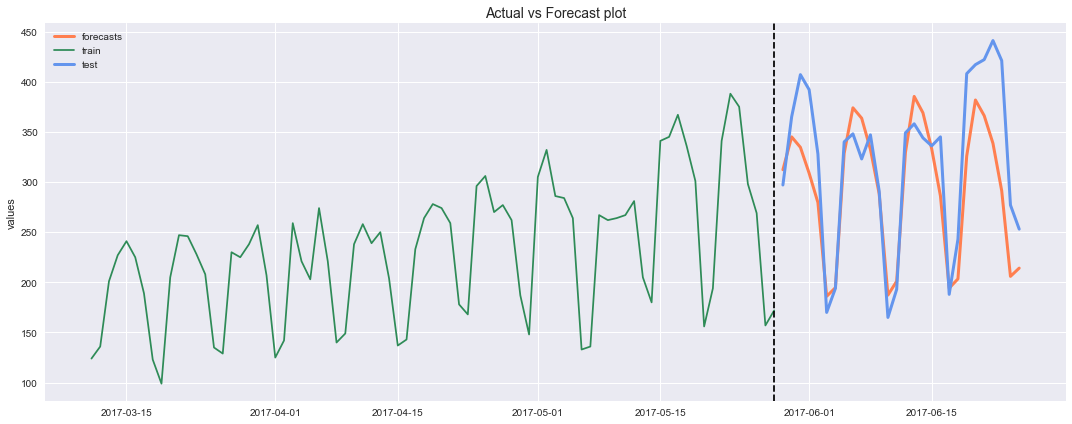

In [26]:
us.plot_forecasts(
    posts[800:-fh],
    tgt_preds_pruned[tgt_preds_pruned > 0].fillna(0),
    posts.index[800:], 
    y_test=posts[-fh:])

In [27]:
tgt_preds_pruned

,y_pred,low_80,up_80,low_95,up_95
0,312.224164,56.298852,1209.718999,18.099198,2246.686863
1,344.978222,82.742102,1111.410844,33.340558,1917.246081
2,334.583039,64.239388,1246.179770,21.737719,2278.708004
3,308.705372,119.323653,707.323423,67.624064,1056.153244
4,279.546523,33.567650,1378.687790,7.566999,2807.873721
5,186.052173,54.171242,524.588721,25.203264,856.352259
6,194.673788,28.497992,856.165165,7.677048,1669.958627
7,328.565245,113.178415,820.662333,59.299878,1272.303154
8,373.963019,137.159962,891.469524,75.025533,1354.397367
9,363.594666,136.275793,852.756433,75.644644,1286.404908


In [28]:
best_fasts.get_params()

{'criterion': 'friedman_mse',
 'lasso_alpha': 0.002576484846064013,
 'learning_rate': 0.6160378151881551,
 'loss': 'quantile',
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50,
 'quantile_reg': True,
 'subsample': 0.6454248871405033}

### Inference- forecasts

Train on full data set, predict the future w/o test comparison.

In [29]:
# once and for all
full_series_index = pd.date_range(start=posts.index[0], periods=(len(posts) + fh))
print(full_series_index)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2017-07-14', '2017-07-15', '2017-07-16', '2017-07-17',
               '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21',
               '2017-07-22', '2017-07-23'],
              dtype='datetime64[ns]', length=935, freq='D')


In [30]:
print("=== Fit best model upon full X, y (using best parameters from rdn search)...")

t0 = time()
best_fasts.fit(X, y)
t1 = time()

=== Fit best model upon full X, y (using best parameters from rdn search)...
X cols 21
X_sel_ cols 13
with quantile regression.
self.gbr_fitted_.n_features = 13


In [31]:
print(f"Time of fitting: {(t1 - t0):.2f} s")
print()
print("=== Compare best estimator baselines...")

_, spreds_full, tgt_fcs_full = best_fasts.compare_to_baselines(
    y, 
    season=7, 
    fh=fh,
    bck_transformer=power,
    prune=True
)

Time of fitting: 1.31 s

=== Compare best estimator baselines...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[1.5819989234797962, 1.707247128103406, 2.3089884827375284, 2.3781219174279, 2.31251046993796, 2.2948293638864445, 2.2625462837832804, 1.5268244683971135, 1.1836406498678076, 2.0179722749983986, 1.9799996730908356, 2.013794773357739, 2.071367996918373, 2.0345804936610654, 1.218124231566667, 1.0142531753011972, 1.776124964761202, 2.026296633510795, 1.923601787246736, 2.03044359900336, 1.9969813291920346]
length of first Lasso test window: 21
[0.04464608532226655, 0.34394969507556494, 0.2927484731221819, 0.17979335312641842, 0.15987279148158828, 0.09856409695558499, 0.23362608726603806, 0.2566925302980594, -0.009045221562517858, 0.20713973401932595, -0.08376431234649728, -0.09628115144775728, -0.10399668975535814]
length of first GradBoost test window (residuals): 13

... gonna predict quantiles as well.

l

=== Plot forecasts against simple preds...

full_time_series_df
            orig_scale_posts   forecasts       mean  naive       drift  \
2017-07-19               NaN  423.712417  73.371287  253.0  265.801807   
2017-07-20               NaN  437.228937  73.371287  253.0  267.729824   
2017-07-21               NaN  398.147658  73.371287  253.0  267.729824   
2017-07-22               NaN  283.578001  73.371287  253.0  267.729824   
2017-07-23               NaN  284.293136  73.371287  253.0  269.669661   

            snaive      low_80       up_80      low_95        up_95  
2017-07-19   422.0  182.878139  891.579574  111.489999  1281.899229  
2017-07-20   441.0  206.657353  856.032361  133.588465  1191.360459  
2017-07-21   421.0  182.702264  798.184047  115.889371  1122.853964  
2017-07-22   277.0  133.189468  558.029834   85.750507   778.418576  
2017-07-23   253.0  139.554056  539.848367   92.403571   740.899431  


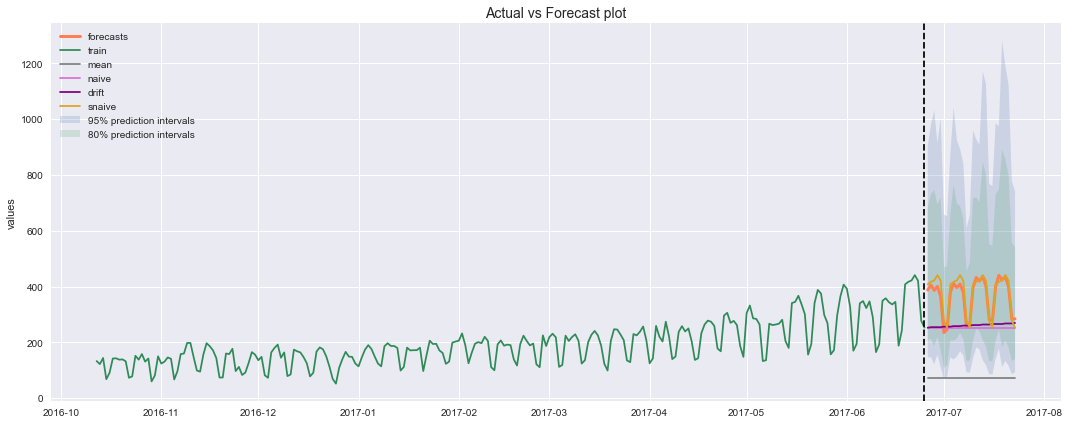

In [32]:
print("=== Plot forecasts against simple preds...")

# it would be useful to write a zoom util to avoid slicing...
us.plot_forecasts(
    posts[650:], 
    tgt_fcs_full[tgt_fcs_full > 0].fillna(0),
    full_series_index[650:], 
    simple_preds=spreds_full,
    return_pred_int=True
)

Luckily, forecast intervals are pretty narrow despite power transformation of data.

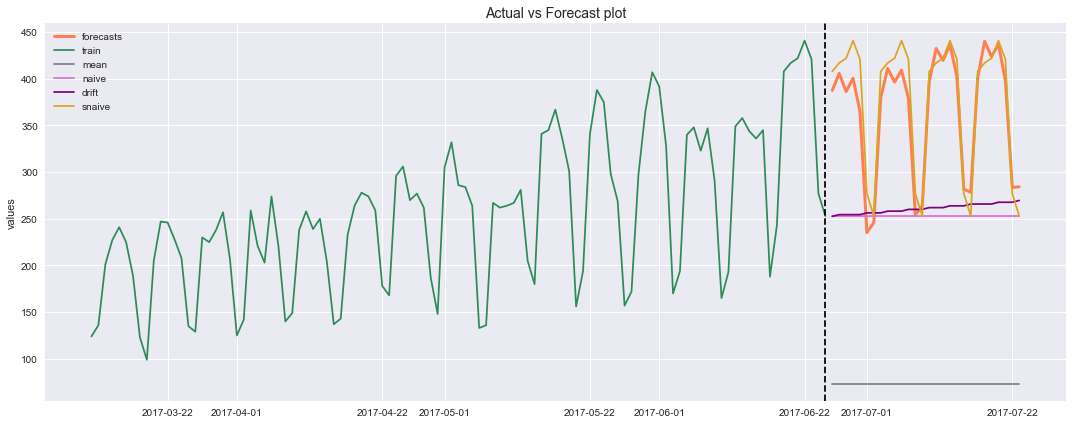

In [33]:
us.plot_forecasts(
    posts[800:], 
    tgt_fcs_full[tgt_fcs_full > 0].fillna(0),
    full_series_index[800:], 
    simple_preds=spreds_full
)

### log 2 exp

In [34]:
posts_y_log = np.log1p(posts.values)
posts_y_log[:10]

array([2.19722458, 2.48490665, 2.48490665, 2.19722458, 3.33220451,
       2.89037176, 3.29583687, 3.17805383, 2.89037176, 1.94591015])

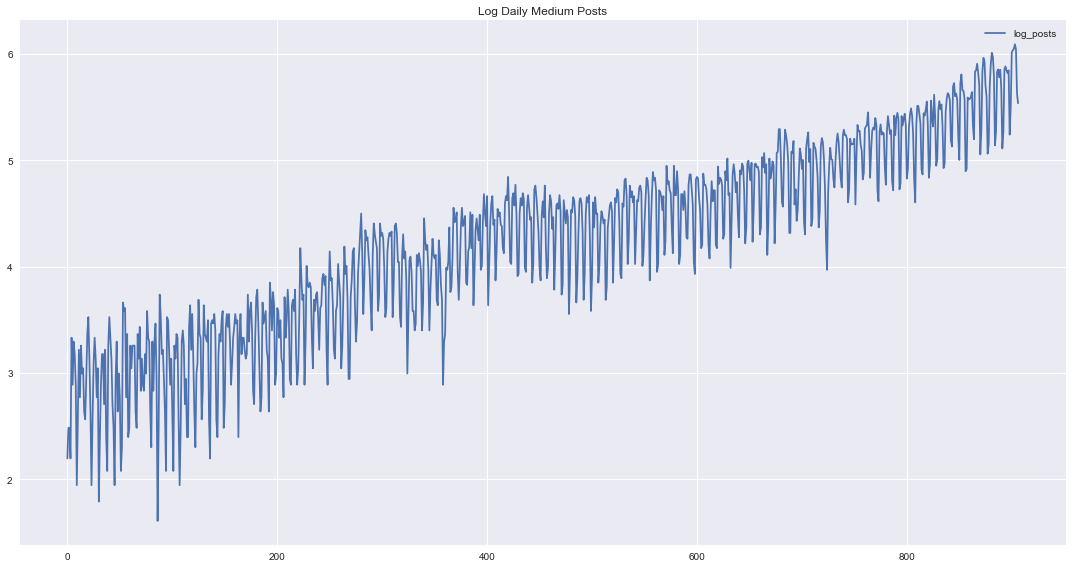

In [35]:
plt.figure(figsize=(15, 8))
plt.plot(posts_y_log, label="log_posts")
plt.title("Log Daily Medium Posts")
plt.legend()    
plt.tight_layout()

In [36]:
# inverse transform
np.expm1(posts_y_log)

array([  8.,  11.,  11.,   8.,  27.,  17.,  26.,  23.,  17.,   6.,  12.,
        24.,  15.,  25.,  19.,  20.,  13.,  12.,  18.,  28.,  33.,  22.,
        13.,   6.,  12.,  21.,  27.,  22.,  15.,  20.,   5.,  10.,  17.,
        23.,  23.,  14.,  24.,  10.,   7.,  25.,  33.,  27.,  22.,  14.,
        11.,   6.,  18.,  26.,  13.,  19.,  15.,   7.,   9.,  38.,  35.,
        36.,  15.,  28.,  10.,  11.,  25.,  20.,  25.,  25.,  25.,  13.,
        11.,  28.,  22.,  30.,  16.,  22.,  17.,  16.,  23.,  19.,  35.,
        27.,  26.,  13.,   9.,  26.,  16.,  26.,  31.,  18.,   4.,  11.,
        41.,  33.,  23.,  24.,  18.,  13.,   7.,  33.,  32.,  23.,  17.,
        22.,  13.,   7.,  25.,  22.,  28.,  27.,  12.,   6.,  11.,  26.,
        29.,  25.,  14.,  18.,  10.,  10.,  30.,  37.,  24.,  34.,  22.,
        13.,   9.,  19.,  21.,  39.,  28.,  27.,  12.,  16.,  37.,  28.,
        27.,  26.,  32.,  12.,   8.,  31.,  32.,  31.,  34.,  29.,  12.,
        10.,  23.,  28.,  26.,  32.,  35.,  11.,  1

In [37]:
X_log, y_log = us.embed_to_X_y(
    pd.Series(posts_y_log), 
    n_lags=n_lags, name='log_posts')

display(X_log)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
0,3.526361,3.367296,2.944439,2.564949,2.639057,3.044522,2.995732,3.258097,2.772589,3.218876,...,1.945910,2.890372,3.178054,3.295837,2.890372,3.332205,2.197225,2.484907,2.484907,2.197225
1,3.135494,3.526361,3.367296,2.944439,2.564949,2.639057,3.044522,2.995732,3.258097,2.772589,...,2.564949,1.945910,2.890372,3.178054,3.295837,2.890372,3.332205,2.197225,2.484907,2.484907
2,2.639057,3.135494,3.526361,3.367296,2.944439,2.564949,2.639057,3.044522,2.995732,3.258097,...,3.218876,2.564949,1.945910,2.890372,3.178054,3.295837,2.890372,3.332205,2.197225,2.484907
3,1.945910,2.639057,3.135494,3.526361,3.367296,2.944439,2.564949,2.639057,3.044522,2.995732,...,2.772589,3.218876,2.564949,1.945910,2.890372,3.178054,3.295837,2.890372,3.332205,2.197225
4,2.564949,1.945910,2.639057,3.135494,3.526361,3.367296,2.944439,2.564949,2.639057,3.044522,...,3.258097,2.772589,3.218876,2.564949,1.945910,2.890372,3.178054,3.295837,2.890372,3.332205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,6.035481,6.013715,5.497168,5.241747,5.846439,5.820083,5.843544,5.883322,5.857933,5.267858,...,5.676754,5.852202,5.780744,5.855072,5.831882,5.273000,5.141664,5.796058,5.973810,6.011267
882,6.047372,6.035481,6.013715,5.497168,5.241747,5.846439,5.820083,5.843544,5.883322,5.857933,...,5.111988,5.676754,5.852202,5.780744,5.855072,5.831882,5.273000,5.141664,5.796058,5.973810
883,6.091310,6.047372,6.035481,6.013715,5.497168,5.241747,5.846439,5.820083,5.843544,5.883322,...,5.267858,5.111988,5.676754,5.852202,5.780744,5.855072,5.831882,5.273000,5.141664,5.796058
884,6.045005,6.091310,6.047372,6.035481,6.013715,5.497168,5.241747,5.846439,5.820083,5.843544,...,5.857933,5.267858,5.111988,5.676754,5.852202,5.780744,5.855072,5.831882,5.273000,5.141664


In [38]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=test_size, random_state=42, shuffle=False)

In [39]:
fasts_log = es.FASTSRegressor(
    quantile_reg=True,
    )

In [40]:
print("=== TS Randomized Search CV...")
print()

rscv_log = vd.TSRandomizedSearchCV(
    estimator=fasts_log, n_split=3, param_distro=fasts_params, fh=fh, 
    test_size=test_size, n_iter=n_iter, n_jobs=n_jobs
)

failed = 0
try:
    t0 = time()
    rscv_log.fit(X_train_log, y_train_log)
    t1 = time()
except ValueError as ve:
    failed = 1
    print("ValueError:", ve)
    # adjust learning_rate distro for spanning little numbers?
    fasts_params["lasso_alpha"] = vd.loguniform(1e-3, 1e-1)
    # fasts_params["learning_rate"] = vd.loguniform(1e-4, 1e-2)
except Exception as e:
    failed = 1
    print("Mysterious Exception:", e)

=== TS Randomized Search CV...

Best validation rmse score overall: 0.251 ± 0.020
Refitting best estimator...
X cols 21
X_sel_ cols 5
with quantile regression.
self.gbr_fitted_.n_features = 5


In [41]:
if failed:
    try:
        t0 = time()
        rscv_log.fit(X_train_log, y_train_log)
        t1 = time()
    except ValueError as ve:
        failed = 1
        print("ValueError:", ve)
    except Exception as e:
        failed = 1
        print("Mysterious Exception:", e)

Full time of Search: 65.69 s

=== Compare best estimator to baselines on test data...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[5.153291594497779, 5.062595033026967, 5.598421958998375, 5.700443573390687, 5.929589143389895, 5.963579343618446, 5.834810737062605, 5.272999558563747, 5.056245805348308, 5.71042701737487, 5.820082930352362, 5.908082938168931, 5.846438775057725, 5.834810737062605, 5.198497031265826, 5.327876168789581, 5.641907070938114, 5.5909869805108565, 5.579729825986222, 5.572154032177765, 5.5909869805108565]
length of first Lasso test window: 21
[0.0505777692939704, -0.024019799200064362, 0.05721252488400719, 0.07919224876549524, 0.2745725008943536]
length of first GradBoost test window (residuals): 5

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 21
[0.0505777692939704, -0.024019799200064362, 0.05721252488400719, 0.07919224876549524, 0.27

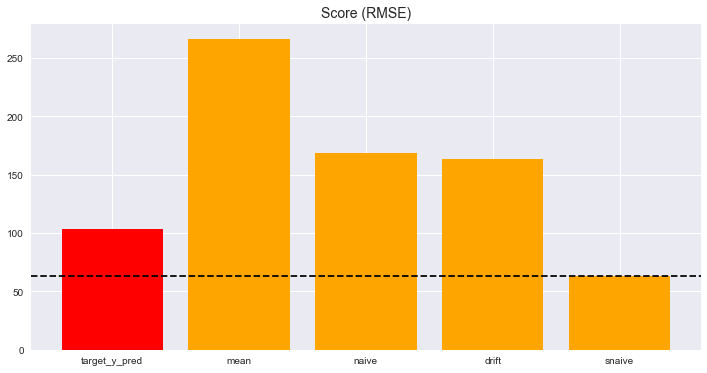

In [42]:
print(f"Full time of Search: {(t1 - t0):.2f} s")
print()

best_fasts_log = rscv_log.best_params_['best_estimator']

print("=== Compare best estimator to baselines on test data...")

scores_log, spreds_log, tgt_preds_log = best_fasts_log.compare_to_baselines(
    y_train_log, 
    y_test_log, 
    # posts[-fh:],
    season=7,
    fh=fh, 
    bar_plot=True,
    bck_transformer=np.expm1,
    prune=True
)

In [74]:
us.mean_absolute_percentage_error(
    posts.values[-fh:],
    tgt_preds_log[tgt_preds_log > 0].fillna(0)["y_pred"])

25.05179468800383

In [43]:
tgt_preds_log

,y_pred,low_80,up_80,low_95,up_95
0,270.609895,46.908029,1538.865805,18.058627,3869.789536
1,292.617917,49.823040,1695.307060,19.016856,4305.944123
2,294.097464,49.620163,1719.312795,18.841580,4387.890050
3,267.755225,46.923993,1506.165135,18.175686,3765.716400
4,250.229584,46.602204,1324.911386,18.671108,3207.578927
5,167.321921,32.408621,847.052645,13.150480,2001.212634
6,171.216856,27.249399,1048.885885,9.812912,2741.891597
7,264.611588,44.064393,1564.526814,16.561086,4016.377825
8,290.912443,47.877954,1742.380559,17.914238,4504.223660
9,295.344196,54.913913,1569.626670,22.054089,3808.297403



full_time_series_df
            orig_scale_posts   forecasts  y_test       mean  naive  \
published                                                            
2017-06-21               NaN  257.657642   422.0  66.323389  172.0   
2017-06-22               NaN  236.713493   441.0  66.323389  172.0   
2017-06-23               NaN  217.581726   421.0  66.323389  172.0   
2017-06-24               NaN  158.153796   277.0  66.323389  172.0   
2017-06-25               NaN  159.452922   253.0  66.323389  172.0   

                 drift  snaive     low_80        up_80     low_95        up_95  
published                                                                       
2017-06-21  182.094058   375.0  49.513851  1323.463983  20.212261  3153.014321  
2017-06-22  182.094058   298.0  44.017639  1254.234750  17.597890  3037.393275  
2017-06-23  182.094058   269.0  39.617763  1175.282669  15.612176  2875.081437  
2017-06-24  182.094058   157.0  25.100872   969.463028   8.989361  2534.690847  
20

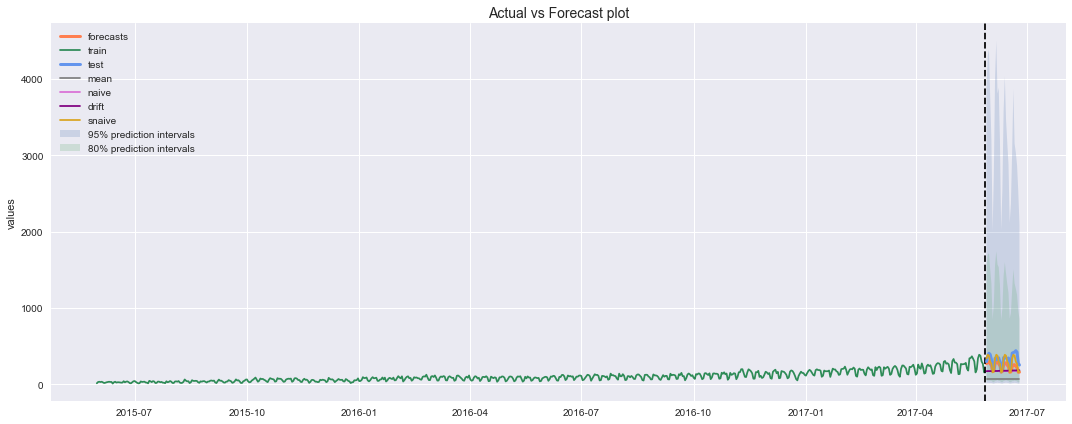

In [44]:
us.plot_forecasts(
    posts[150:-fh],
    tgt_preds_log[tgt_preds_log > 0].fillna(0),
    posts.index[150:], 
    y_test=posts[-fh:],
    simple_preds=spreds_log,
    return_pred_int=True)

Power transformations make prediction intervals **explode**, in particular `np.log` - `np.exp`.

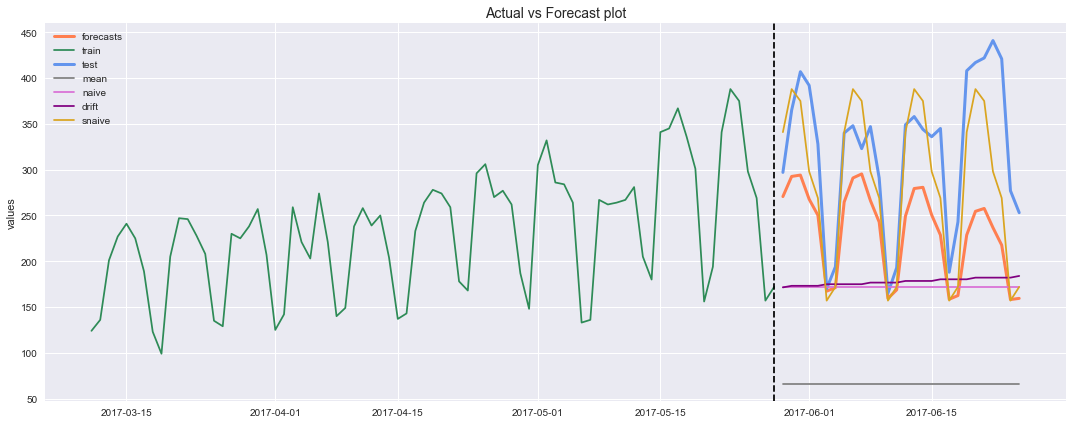

In [45]:
us.plot_forecasts(
    posts[800:-fh],
    tgt_preds_log[tgt_preds_log > 0].fillna(0),
    posts.index[800:], 
    y_test=posts[-fh:],
    simple_preds=spreds_log)

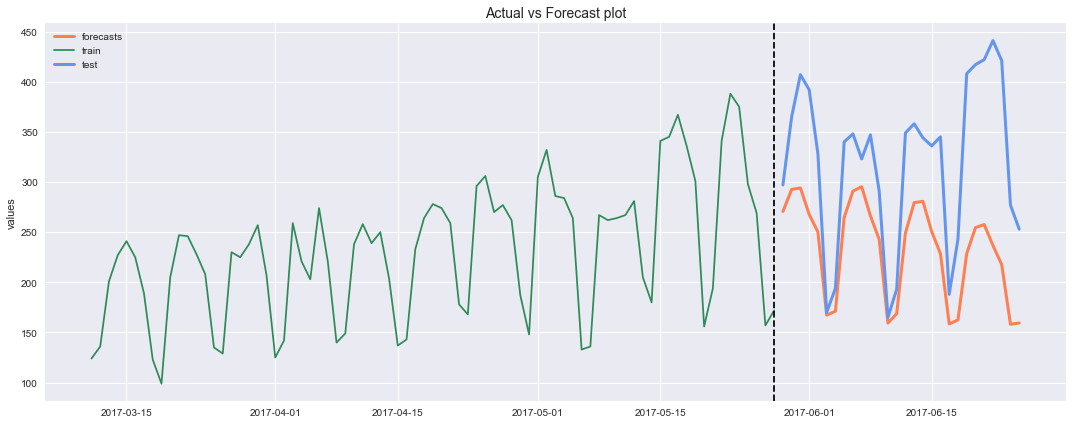

In [46]:
us.plot_forecasts(
    posts[800:-fh],
    tgt_preds_log[tgt_preds_log > 0].fillna(0),
    posts.index[800:], 
    y_test=posts[-fh:])

Log() does not seem to be a good transformation...

##### Check

In [47]:
# no cross-val.
fasts_log_1 = es.FASTSRegressor(
    lasso_alpha=0.01,
    quantile_reg=True,
    )

In [48]:
%time fasts_log_1.fit(X_train_log, y_train_log)

X cols 21
X_sel_ cols 6
with quantile regression.
self.gbr_fitted_.n_features = 6
Wall time: 264 ms


FASTSRegressor(lasso_alpha=0.01, loss='quantile', quantile_reg=True)

In [49]:
tgt_preds_log_pruned = fasts_log_1.predict(fh, pred_int=True, prune=True)
tgt_preds_log_pruned


=== Trying to make forecasts w FASTSRegressor...



test windows:
[5.153291594497779, 5.062595033026967, 5.598421958998375, 5.700443573390687, 5.929589143389895, 5.963579343618446, 5.834810737062605, 5.272999558563747, 5.056245805348308, 5.71042701737487, 5.820082930352362, 5.908082938168931, 5.846438775057725, 5.834810737062605, 5.198497031265826, 5.327876168789581, 5.641907070938114, 5.5909869805108565, 5.579729825986222, 5.572154032177765, 5.5909869805108565]
length of first Lasso test window: 21
[-0.04635692521670265, -0.11688544131445422, -0.03709286733900541, -0.04835212520865273, 0.14252961477178072, 0.17245313901924053]
length of first GradBoost test window (residuals): 6

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 21
[-0.04635692521670265, -0.11688544131445422, -0.03709286733900541, -0.04835212520865273, 0.14252961477178072, 0.17245313901924053]
length of first GradBoost quantile test window (0.95): 6


You're here: 

,y_pred,low_80,up_80,low_95,up_95
0,5.711773,3.547786,7.875759,2.398168,9.025377
1,5.817618,3.660629,7.974607,2.514729,9.120507
2,5.825049,3.710851,7.939247,2.587684,9.062415
3,5.730629,3.605021,7.856237,2.475791,8.985466
4,5.642770,3.556617,7.728923,2.448348,8.837192
5,5.231794,3.165056,7.298532,2.067101,8.396486
6,5.267049,3.111808,7.422289,1.966836,8.567261
7,5.745139,3.581778,7.908501,2.432492,9.057787
8,5.871292,3.652147,8.090437,2.473227,9.269358
9,5.890485,3.786251,7.994720,2.668376,9.112594


In [50]:
tgt_preds_pruned = np.expm1(tgt_preds_log_pruned)
tgt_preds_pruned

,y_pred,low_80,up_80,low_95,up_95
0,301.406694,33.736334,2631.684528,10.003004,8310.348884
1,335.170265,37.885791,2905.214456,11.363253,9139.834617
2,337.677737,39.888594,2804.247087,12.298929,8623.950674
3,307.162918,35.782438,2580.786008,10.891112,7985.165322
4,281.243498,34.044435,2272.153824,10.569217,6884.633739
5,186.128183,22.690068,1477.128166,6.901885,4430.468755
6,192.842999,21.461613,1671.858869,6.148025,5255.711968
7,311.667181,34.937363,2719.309965,10.387219,8584.131315
8,353.707058,37.557374,3262.113741,10.860655,10606.938109
9,360.580697,43.090784,2964.259133,13.416541,9067.791224


In [51]:
us.mean_absolute_percentage_error(
    posts.values[-fh:],
    tgt_preds_pruned[tgt_preds_pruned > 0].fillna(0)["y_pred"])

12.068691101769303


full_time_series_df
            orig_scale_posts   forecasts  y_test     low_80        up_80  \
published                                                                  
2017-06-21               NaN  357.751933   422.0  45.106985  2790.398059   
2017-06-22               NaN  325.862145   441.0  40.218398  2591.018764   
2017-06-23               NaN  286.151464   421.0  33.661610  2377.884395   
2017-06-24               NaN  204.081656   277.0  21.596224  1860.305927   
2017-06-25               NaN  209.045799   253.0  25.643491  1654.910559   

               low_95        up_95  
published                           
2017-06-21  14.502736  8300.950579  
2017-06-22  12.719935  7786.125890  
2017-06-23  10.272543  7313.761761  
2017-06-24   6.000939  6006.549032  
2017-06-25   7.896252  4958.305971  


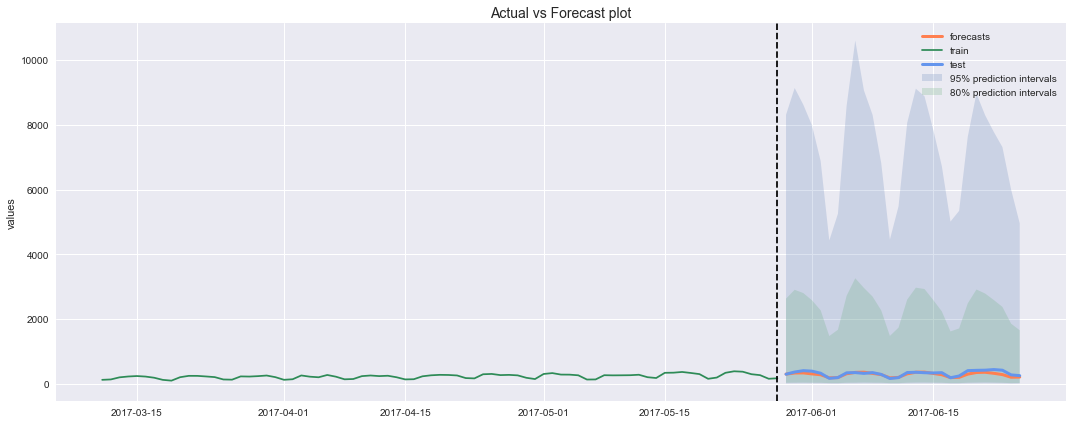

In [52]:
us.plot_forecasts(
    posts[800:-fh],
    tgt_preds_pruned[tgt_preds_pruned > 0].fillna(0),
    posts.index[800:], 
    y_test=posts[-fh:],
    return_pred_int=True)

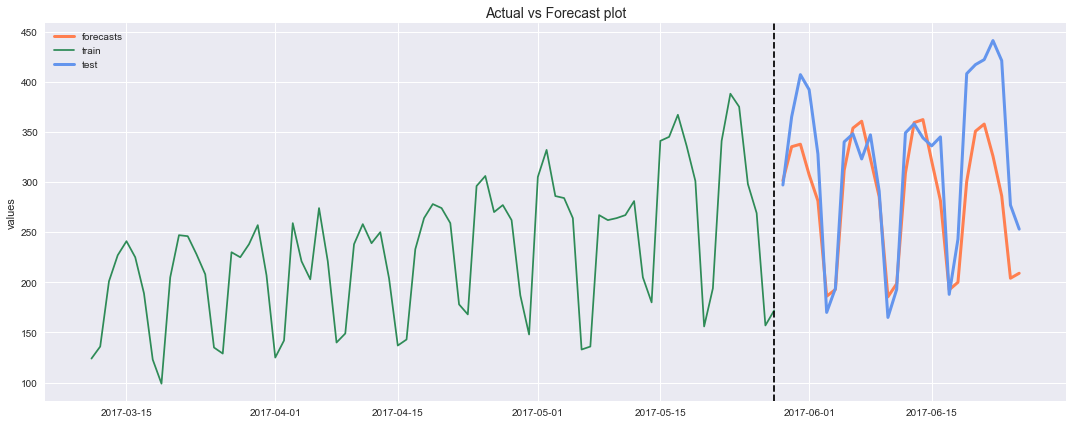

In [53]:
us.plot_forecasts(
    posts[800:-fh],
    tgt_preds_pruned[tgt_preds_pruned > 0].fillna(0),
    posts.index[800:], 
    y_test=posts[-fh:])

Hyperparameter optimization was **sub-optimal**. This model with manually set `alpha` does better.

**Refit** on full log data.

In [54]:
print("=== Fit best model upon full X_log, y_log (using best parameters from rdn search)...")

t0 = time()
best_fasts_log.fit(X_log, y_log)
t1 = time()

=== Fit best model upon full X_log, y_log (using best parameters from rdn search)...
X cols 21
X_sel_ cols 5
with quantile regression.
self.gbr_fitted_.n_features = 5


In [55]:
print(f"Time of fitting: {(t1 - t0):.2f} s")
print()
print("=== Compare best estimator baselines...")

_, spreds_full_log, tgt_fcs_full_log = best_fasts_log.compare_to_baselines(
    y_log, season=7, fh=fh, bck_transformer=np.expm1, prune=True)

Time of fitting: 1.13 s

=== Compare best estimator baselines...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[5.537334267018537, 5.627621113690637, 6.045005314036012, 6.091309882077698, 6.0473721790462776, 6.035481432524756, 6.013715156042802, 5.497168225293202, 5.241747015059643, 5.846438775057725, 5.820082930352362, 5.84354441703136, 5.883322388488279, 5.857933154483459, 5.267858159063328, 5.111987788356544, 5.676753802268282, 5.8522024797744745, 5.780743515792329, 5.855071922202427, 5.831882477283517]
length of first Lasso test window: 21
[0.1837419450201212, 0.4010088734867452, 0.33804774264235604, 0.29555296545380116, 0.25265713581684945]
length of first GradBoost test window (residuals): 5

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 21
[0.1837419450201212, 0.4010088734867452, 0.33804774264235604, 0.29555296545380116, 0.25265713581684945]
length of

In [56]:
tgt_fcs_full_log

,y_pred,low_80,up_80,low_95,up_95
0,323.780047,152.435624,686.467980,102.019079,1022.908187
1,337.647573,125.335275,906.760547,73.822288,1531.727506
2,331.586899,111.970824,978.138166,62.656468,1736.671742
3,339.502184,143.433312,801.735434,90.580279,1265.012055
4,318.734459,117.488754,861.783351,68.927615,1460.942095
5,209.404046,74.827184,582.825749,43.091963,1003.034730
6,216.784592,76.560386,610.525177,43.816121,1057.327393
7,306.530583,119.595744,783.232149,72.341355,1288.518842
8,324.382226,129.263519,811.764721,79.096438,1320.826481
9,322.110770,146.318343,707.673256,96.062241,1074.604362


=== Plot forecasts against simple preds...

full_time_series_df
            orig_scale_posts   forecasts      mean  naive       drift  snaive  \
2017-07-19               NaN  292.731950  69.64695  253.0  269.426407   422.0   
2017-07-20               NaN  296.401186  69.64695  253.0  269.426407   441.0   
2017-07-21               NaN  282.549679  69.64695  253.0  272.144238   421.0   
2017-07-22               NaN  209.390004  69.64695  253.0  272.144238   277.0   
2017-07-23               NaN  206.397203  69.64695  253.0  272.144238   253.0   

                low_80       up_80     low_95        up_95  
2017-07-19   96.712223  881.985319  53.451541  1583.499846  
2017-07-20  126.789232  691.135514  80.584194  1083.125017  
2017-07-21   97.164701  818.035966  54.875624  1437.917640  
2017-07-22   73.792096  590.826622  42.175210  1024.216859  
2017-07-23   82.273925  515.531433  50.283531   837.740990  


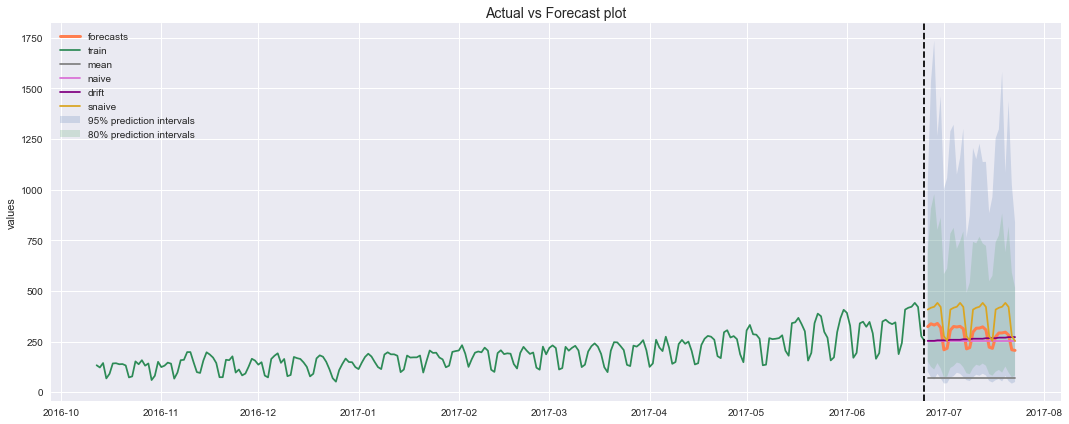

In [57]:
print("=== Plot forecasts against simple preds...")

us.plot_forecasts(
    posts[650:], 
    tgt_fcs_full_log[tgt_fcs_full_log > 0].fillna(0),
    full_series_index[650:], 
    simple_preds=spreds_full_log,
    return_pred_int=True
)

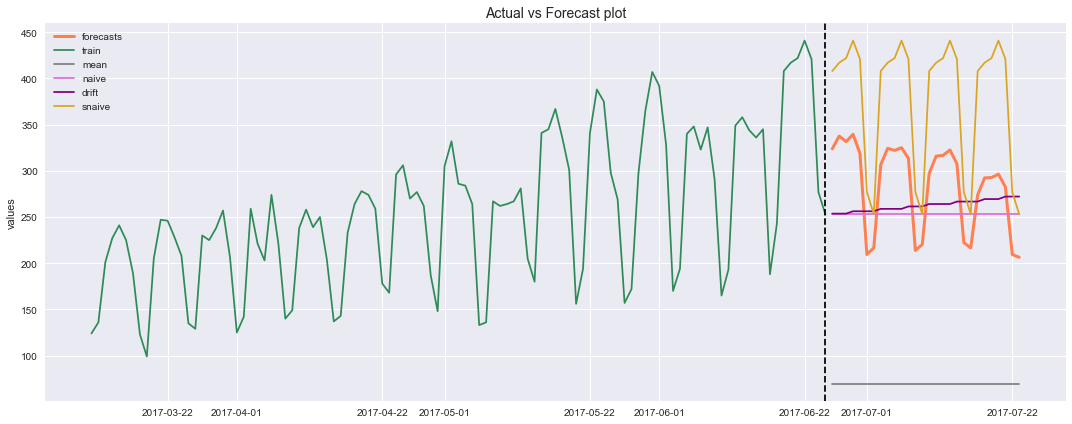

In [58]:
us.plot_forecasts(
    posts[800:], 
    tgt_fcs_full_log[tgt_fcs_full_log > 0].fillna(0),
    full_series_index[800:], 
    simple_preds=spreds_full_log
)

### MinMax scaling

In [59]:
posts_y_scale = scaler.fit_transform(posts.values.reshape(-1, 1)).ravel()
posts_y_scale[:10]

array([1.08237986, 1.14416476, 1.14416476, 1.08237986, 1.47368421,
       1.26773455, 1.45308924, 1.39130435, 1.26773455, 1.04118993])

In [60]:
X_sc, y_sc = us.embed_to_X_y(
    pd.Series(posts_y_scale), 
    n_lags=n_lags, name='sscaled_posts')

In [61]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(
    X_sc, y_sc, test_size=test_size, random_state=42, shuffle=False)

In [62]:
display(X_train_sc)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
0,1.597254,1.494279,1.288330,1.164760,1.185355,1.329519,1.308924,1.432494,1.226545,1.411899,...,1.041190,1.267735,1.391304,1.453089,1.267735,1.473684,1.082380,1.144165,1.144165,1.082380
1,1.370709,1.597254,1.494279,1.288330,1.164760,1.185355,1.329519,1.308924,1.432494,1.226545,...,1.164760,1.041190,1.267735,1.391304,1.453089,1.267735,1.473684,1.082380,1.144165,1.144165
2,1.185355,1.370709,1.597254,1.494279,1.288330,1.164760,1.185355,1.329519,1.308924,1.432494,...,1.411899,1.164760,1.041190,1.267735,1.391304,1.453089,1.267735,1.473684,1.082380,1.144165
3,1.041190,1.185355,1.370709,1.597254,1.494279,1.288330,1.164760,1.185355,1.329519,1.308924,...,1.226545,1.411899,1.164760,1.041190,1.267735,1.391304,1.453089,1.267735,1.473684,1.082380
4,1.164760,1.041190,1.185355,1.370709,1.597254,1.494279,1.288330,1.164760,1.185355,1.329519,...,1.432494,1.226545,1.411899,1.164760,1.041190,1.267735,1.391304,1.453089,1.267735,1.473684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,8.908467,7.940503,4.913043,4.130435,7.116705,7.837529,8.475973,8.022883,7.940503,4.624714,...,6.704805,6.416476,6.354691,6.313501,6.416476,3.718535,3.656751,6.354691,6.766590,6.807780
854,8.640732,8.908467,7.940503,4.913043,4.130435,7.116705,7.837529,8.475973,8.022883,7.940503,...,5.139588,6.704805,6.416476,6.354691,6.313501,6.416476,3.718535,3.656751,6.354691,6.766590
855,7.054920,8.640732,8.908467,7.940503,4.913043,4.130435,7.116705,7.837529,8.475973,8.022883,...,4.624714,5.139588,6.704805,6.416476,6.354691,6.313501,6.416476,3.718535,3.656751,6.354691
856,6.457666,7.054920,8.640732,8.908467,7.940503,4.913043,4.130435,7.116705,7.837529,8.475973,...,7.940503,4.624714,5.139588,6.704805,6.416476,6.354691,6.313501,6.416476,3.718535,3.656751


In [63]:
fasts_sc = es.FASTSRegressor(
    quantile_reg=True,
    )

print("=== TS Randomized Search CV...")
print()

rscv_sc = vd.TSRandomizedSearchCV(
    estimator=fasts_sc, n_split=3, param_distro=fasts_params, fh=fh, 
    test_size=test_size, n_iter=n_iter, 
    n_jobs=n_jobs
)

t0 = time()
rscv_sc.fit(X_train_sc, y_train_sc)
t1 = time()

=== TS Randomized Search CV...

Best validation rmse score overall: 0.512 ± 0.176
Refitting best estimator...
X cols 21
X_sel_ cols 18
with quantile regression.
self.gbr_fitted_.n_features = 18


Full time of Search: 74.56 s

=== Compare best estimator to baselines on test data...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[4.459954233409611, 4.151029748283753, 6.45766590389016, 7.054919908466819, 8.640732265446225, 8.908466819221967, 7.940503432494279, 4.913043478260869, 4.130434782608695, 7.116704805491991, 7.837528604118993, 8.475972540045767, 8.022883295194507, 7.940503432494279, 4.6247139588100685, 5.139588100686499, 6.704805491990847, 6.416475972540045, 6.354691075514874, 6.31350114416476, 6.416475972540045]
length of first Lasso test window: 21
[-0.16577657894557873, -0.28432384899791785, -0.4402578387724727, -0.8443678663034317, 0.4758533557334115, 0.6986996321161012, 0.2947456747747994, 0.44452559049527807, -1.174435958422805, 0.03641055500089063, 0.26684300325046006, 1.2614969609594393, 0.2760235843615604, 0.7507106052844081, 0.03555272527594955, 0.7135888489554052, 0.573182466724516, -0.18027

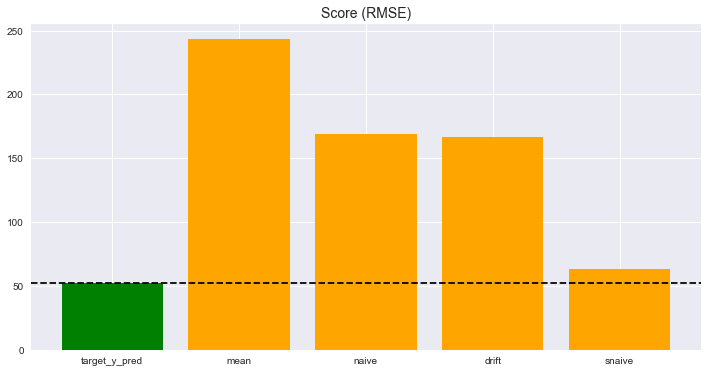

In [64]:
print(f"Full time of Search: {(t1 - t0):.2f} s")
print()

best_fasts_sc = rscv_sc.best_params_['best_estimator']

print("=== Compare best estimator to baselines on test data...")

scores_sc, spreds_sc, tgt_preds_sc = best_fasts_sc.compare_to_baselines(
    y_train_sc, 
    y_test_sc, 
    # posts[-fh:],
    season=7,
    fh=fh, 
    bar_plot=True,
    bck_transformer=scaler
)

In [66]:
us.mean_absolute_percentage_error(
    posts.values[-fh:],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0)["y_pred"])

11.342614922330467


full_time_series_df
            orig_scale_posts   forecasts  y_test       mean  naive  \
published                                                            
2017-06-21               NaN  378.369459   422.0  90.599068  172.0   
2017-06-22               NaN  330.929822   441.0  90.599068  172.0   
2017-06-23               NaN  286.614153   421.0  90.599068  172.0   
2017-06-24               NaN  195.947583   277.0  90.599068  172.0   
2017-06-25               NaN  217.857684   253.0  90.599068  172.0   

                 drift  snaive      low_80       up_80      low_95       up_95  
published                                                                       
2017-06-21  175.886667   375.0  309.429743  447.309175  272.805519  483.933399  
2017-06-22  176.372222   298.0  256.971298  404.888346  217.680832  444.178812  
2017-06-23  176.372222   269.0  209.650841  363.577466  168.764081  404.464226  
2017-06-24  176.372222   157.0  118.375869  273.519296   77.165897  314.729269  
20

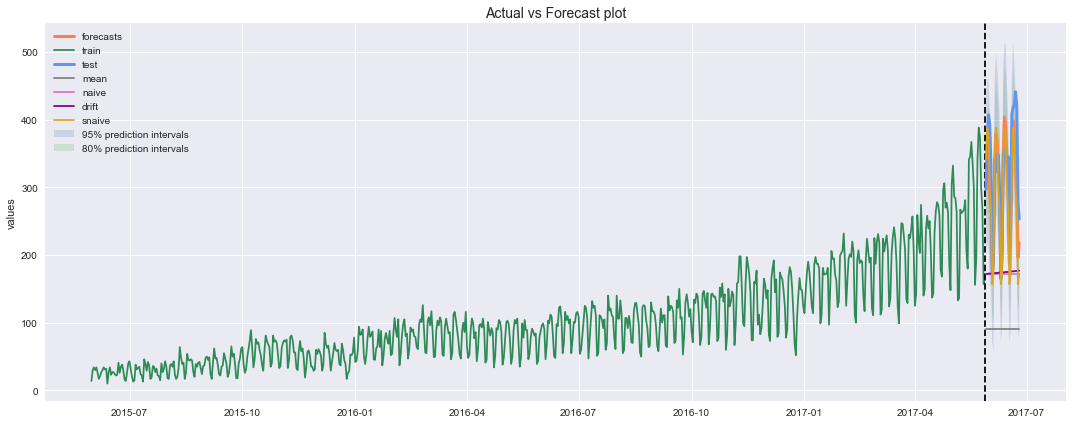

In [67]:
us.plot_forecasts(
    posts[150:-fh],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0),
    posts.index[150:], 
    y_test=posts[-fh:],
    simple_preds=spreds_sc,
    return_pred_int=True)

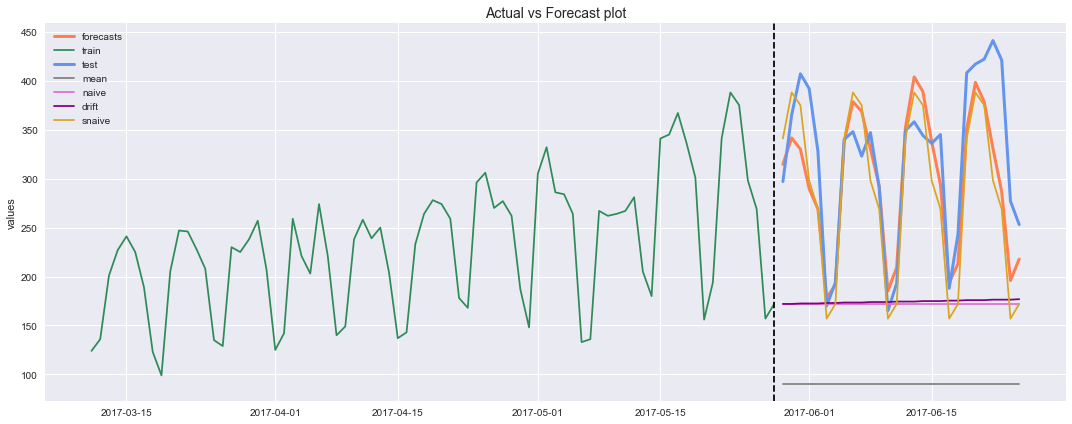

In [68]:
us.plot_forecasts(
    posts[800:-fh],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0),
    posts.index[800:], 
    y_test=posts[-fh:],
    simple_preds=spreds_sc)

In [69]:
us.mean_absolute_percentage_error(
    posts.values[-fh:],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0)["y_pred"])

11.342614922330467

In [70]:
print("=== Fit best model upon full X_sc, y_sc (using best parameters from rdn search)...")

t0 = time()
best_fasts_sc.fit(X_sc, y_sc)
t1 = time()

=== Fit best model upon full X_sc, y_sc (using best parameters from rdn search)...
X cols 21
X_sel_ cols 19
with quantile regression.
self.gbr_fitted_.n_features = 19


In [71]:
print(f"Time of fitting: {(t1 - t0):.2f} s")
print()
print("=== Compare best estimator baselines...")

_, spreds_full_sc, tgt_fcs_full_sc = best_fasts_sc.compare_to_baselines(
    y_sc, season=7, fh=fh, bck_transformer=scaler)

Time of fitting: 3.57 s

=== Compare best estimator baselines...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[6.128146453089244, 6.622425629290618, 9.588100686498855, 10.0, 9.608695652173912, 9.505720823798626, 9.320366132723112, 5.922196796338673, 4.7894736842105265, 8.022883295194507, 7.837528604118993, 8.002288329519452, 8.290617848970252, 8.105263157894736, 4.892448512585812, 4.315789473684211, 6.910755148741418, 8.064073226544622, 7.5697940503432495, 8.084668192219679, 7.919908466819222]
length of first Lasso test window: 21
[-0.40691295921272097, 0.7048242707323453, 0.888653205429522, 0.6142288990618621, 0.5184056664878351, 0.23500365367111087, 0.9181452113680137, 0.7744507928438296, -0.04565927703823025, 1.0877932278248021, -0.4452870451278068, -0.5103334604094396, -0.6501887513696705, 0.14911347630022576, -0.13184452118884948, -0.01423279676987299, -0.30578885292485136, -0.021975519973215896, -1.30091456

=== Plot forecasts against simple preds...

full_time_series_df
            orig_scale_posts   forecasts       mean  naive       drift  \
2017-07-19               NaN  442.925480  97.851016  253.0  258.916667   
2017-07-20               NaN  460.281868  97.851016  253.0  259.402222   
2017-07-21               NaN  425.841816  97.851016  253.0  259.402222   
2017-07-22               NaN  292.192850  97.851016  253.0  259.887778   
2017-07-23               NaN  296.903062  97.851016  253.0  259.887778   

            snaive      low_80       up_80      low_95       up_95  
2017-07-19   422.0  362.136395  523.714565  319.217194  566.633766  
2017-07-20   441.0  394.762912  525.800824  359.955966  560.607770  
2017-07-21   421.0  358.855670  492.827962  323.269279  528.414353  
2017-07-22   277.0  218.842519  365.543181  179.875155  404.510544  
2017-07-23   253.0  237.543548  356.262577  206.008805  387.797319  


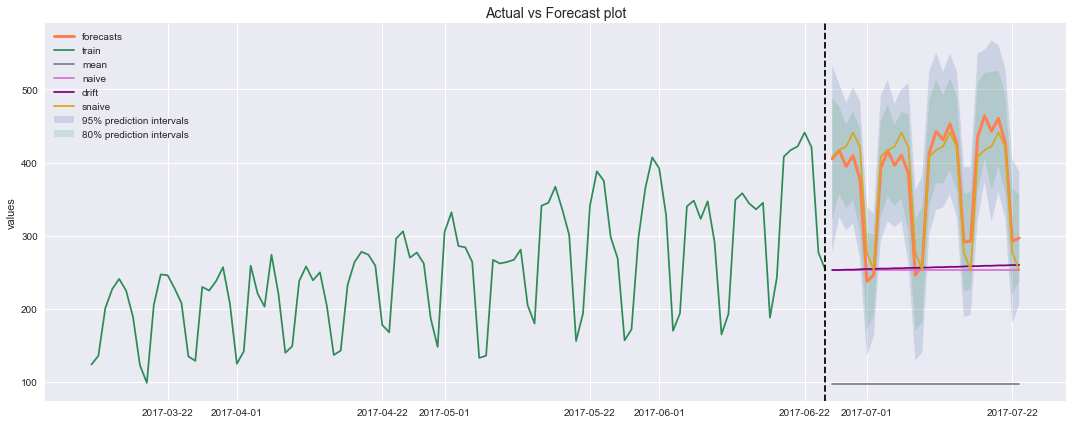

In [72]:
print("=== Plot forecasts against simple preds...")

us.plot_forecasts(
    posts[800:], 
    tgt_fcs_full_sc[tgt_fcs_full_sc > 0].fillna(0),
    full_series_index[800:], 
    simple_preds=spreds_full_sc,
    return_pred_int=True
)

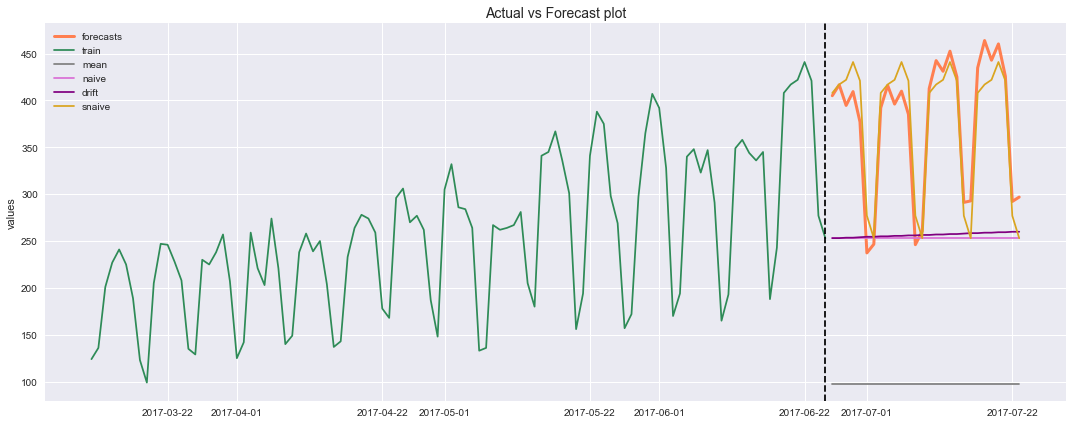

In [73]:
us.plot_forecasts(
    posts[800:], 
    tgt_fcs_full_sc[tgt_fcs_full_sc > 0].fillna(0),
    full_series_index[800:], 
    simple_preds=spreds_full_sc
)

Independently of using *Box-Cox* transformation or just `MinMax` scaling, you can see that FASTS models posts' "up and downs" and respects the weekly cycle. `np.log` transforms needs finer hyperaparam. optimization.

With `n_iter=25`, `FASTSRegressor` on `MinMax` scaled data is the winner model.